In [40]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:


# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [41]:
df = pd.read_csv('timeseries.csv')


In [ ]:
 # Load data from a CSV file named 'timeseries.csv' into a pandas DataFrame.

In [42]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)
# df['time'][78886]

96418                                        20201231:1007
96419                                        20201231:1107
96420                                        20201231:1207
96421                                        20201231:1307
96422                                        20201231:1407
96423                                        20201231:1507
96424                                        20201231:1607
96425                                        20201231:1707
96426                                        20201231:1807
96427                                        20201231:1907
96428                                        20201231:2007
96429                                        20201231:2107
96430                                        20201231:2207
96431                                        20201231:2307
96433    G(i): Global irradiance on the inclined plane ...
96434                           H_sun: Sun height (degree)
96435            T2m: 2-m air temperature (degree Celsiu

In [43]:
df = df[:96431:]  # Truncate the DataFrame to include only the first 96,431 rows.

df_multi = df.iloc[:,1:5]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


      G(i)  H_sun    T2m  WS10m
0        0   0.00  11.17   1.59
1        0   0.00  10.67   1.59
2        0   0.00  10.11   1.79
3        0   0.00   9.88   1.86
4    91.98   2.76   9.77   1.93
5   432.28  15.67  11.48   1.72
6   681.34  27.82  15.42   1.72
7   867.69  38.65  19.13   1.72
8   987.62  47.15  21.08   1.66
9  1034.38  51.71  22.13   1.24
G(i)      object
H_sun    float64
T2m      float64
WS10m    float64
dtype: object


In [44]:
df_multi['G(i)'] = pd.to_numeric(df_multi['G(i)'], errors='coerce')
unique_types = df_multi['G(i)'].apply(type).unique()

print(unique_types)

[<class 'float'>]


In [ ]:
df_multi['G(i)'] = pd.to_numeric(df_multi['G(i)'], errors='coerce')  
# Convert the 'G(i)' column to numeric types, coercing errors into NaN values to handle non-numeric data safely.

unique_types = df_multi['G(i)'].apply(type).unique()  
# Apply the 'type' function to each element in the 'G(i)' column and retrieve the unique data types present.

print(unique_types)  
# Print the array of unique data types found in the 'G(i)' column to inspect the types of data being processed.


In [45]:
df_scaled = df_multi.to_numpy()
correlation = df_multi['G(i)'].corr(df_multi['H_sun'])
print("Pearson Correlation Coefficient:", correlation)

Pearson Correlation Coefficient: 0.900361066319861


In [46]:
print(df_scaled[0:5,0]) # this it the input
print(df_scaled[5,0]) # this is the output

[ 0.    0.    0.    0.   91.98]
432.28


In [47]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,0]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [48]:
WINDOW_SIZE = 24
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("slfejlksdjlfkjdslkjfjlk")
print(y1[0])
X1.shape, y1.shape

[   0.      0.      0.      0.     91.98  432.28  681.34  867.69  987.62
 1034.38  998.94  887.09  702.6   472.43  208.97    0.      0.      0.
    0.      0.      0.      0.      0.      0.  ]
slfejlksdjlfkjdslkjfjlk
0.0


((96407, 24), (96407,))

In [49]:
X_train1, y_train1 = X1[:61367], y1[:61367]
X_val1, y_val1 = X1[61367:70127], y1[61367:70127] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[70128:], y1[70128:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape


((61367, 24), (61367,), (8760, 24), (8760,), (26279, 24), (26279,))

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((24, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=1, mode='min')

In [53]:
cp1 = ModelCheckpoint('model_G(I)/', save_best_only=True)
# metrics , learning rate, loss  can be changed 
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [54]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1,early_stopping])

Epoch 1/100
1915/1918 [============================>.] - ETA: 0s - loss: 81293.8438 - root_mean_squared_error: 285.1208

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 30s 14ms/step - loss: 81193.7109 - root_mean_squared_error: 284.9451 - val_loss: 11906.5430 - val_root_mean_squared_error: 109.1171
Epoch 2/100
1917/1918 [============================>.] - ETA: 0s - loss: 8169.0737 - root_mean_squared_error: 90.3829

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 28s 15ms/step - loss: 8167.7212 - root_mean_squared_error: 90.3754 - val_loss: 7781.6357 - val_root_mean_squared_error: 88.2136
Epoch 3/100
1918/1918 [==============================] - ETA: 0s - loss: 6923.4565 - root_mean_squared_error: 83.2073

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 28s 15ms/step - loss: 6923.4565 - root_mean_squared_error: 83.2073 - val_loss: 7652.2280 - val_root_mean_squared_error: 87.4770
Epoch 4/100
1916/1918 [============================>.] - ETA: 0s - loss: 6824.1646 - root_mean_squared_error: 82.6085

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 28s 15ms/step - loss: 6820.8062 - root_mean_squared_error: 82.5882 - val_loss: 7486.0229 - val_root_mean_squared_error: 86.5218
Epoch 5/100
1918/1918 [==============================] - 21s 11ms/step - loss: 6649.1680 - root_mean_squared_error: 81.5424 - val_loss: 7727.6875 - val_root_mean_squared_error: 87.9073
Epoch 6/100
1918/1918 [==============================] - 21s 11ms/step - loss: 6526.1655 - root_mean_squared_error: 80.7847 - val_loss: 7488.2827 - val_root_mean_squared_error: 86.5349
Epoch 7/100
1918/1918 [==============================] - 23s 12ms/step - loss: 6546.5732 - root_mean_squared_error: 80.9109 - val_loss: 7486.6099 - val_root_mean_squared_error: 86.5252
Epoch 8/100
1916/1918 [============================>.] - ETA: 0s - loss: 6439.2637 - root_mean_squared_error: 80.2450

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 32s 16ms/step - loss: 6448.6475 - root_mean_squared_error: 80.3035 - val_loss: 7285.5205 - val_root_mean_squared_error: 85.3553
Epoch 9/100
1918/1918 [==============================] - 24s 12ms/step - loss: 6350.5088 - root_mean_squared_error: 79.6901 - val_loss: 7574.8208 - val_root_mean_squared_error: 87.0334
Epoch 10/100
1917/1918 [============================>.] - ETA: 0s - loss: 6368.9160 - root_mean_squared_error: 79.8055

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 30s 16ms/step - loss: 6368.0620 - root_mean_squared_error: 79.8001 - val_loss: 7231.2002 - val_root_mean_squared_error: 85.0365
Epoch 11/100
1918/1918 [==============================] - 21s 11ms/step - loss: 6295.3428 - root_mean_squared_error: 79.3432 - val_loss: 7641.2979 - val_root_mean_squared_error: 87.4145
Epoch 12/100
1918/1918 [==============================] - 23s 12ms/step - loss: 6270.8320 - root_mean_squared_error: 79.1886 - val_loss: 7345.1196 - val_root_mean_squared_error: 85.7037
Epoch 13/100
1918/1918 [==============================] - 22s 11ms/step - loss: 6265.3511 - root_mean_squared_error: 79.1540 - val_loss: 7594.9263 - val_root_mean_squared_error: 87.1489
Epoch 14/100
1918/1918 [==============================] - 23s 12ms/step - loss: 6246.9526 - root_mean_squared_error: 79.0377 - val_loss: 7433.0430 - val_root_mean_squared_error: 86.2151
Epoch 15/100
1918/1918 [==============================] - ETA: 0s - loss: 6299.8721

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 31s 16ms/step - loss: 6299.8721 - root_mean_squared_error: 79.3717 - val_loss: 7133.3145 - val_root_mean_squared_error: 84.4590
Epoch 16/100
1918/1918 [==============================] - 22s 11ms/step - loss: 6185.4800 - root_mean_squared_error: 78.6478 - val_loss: 7281.5137 - val_root_mean_squared_error: 85.3318
Epoch 17/100
1918/1918 [==============================] - 22s 11ms/step - loss: 6235.5742 - root_mean_squared_error: 78.9657 - val_loss: 7390.6836 - val_root_mean_squared_error: 85.9691
Epoch 18/100
1918/1918 [==============================] - 22s 12ms/step - loss: 6252.8472 - root_mean_squared_error: 79.0749 - val_loss: 7216.0674 - val_root_mean_squared_error: 84.9474
Epoch 19/100
1914/1918 [============================>.] - ETA: 0s - loss: 6191.3608 - root_mean_squared_error: 78.6852

INFO:tensorflow:Assets written to: model_G(I)\assets


INFO:tensorflow:Assets written to: model_G(I)\assets


1918/1918 [==============================] - 31s 16ms/step - loss: 6187.3037 - root_mean_squared_error: 78.6594 - val_loss: 7129.9956 - val_root_mean_squared_error: 84.4393
Epoch 20/100
1918/1918 [==============================] - 24s 12ms/step - loss: 6184.6733 - root_mean_squared_error: 78.6427 - val_loss: 7222.1318 - val_root_mean_squared_error: 84.9831
Epoch 21/100
1918/1918 [==============================] - 22s 12ms/step - loss: 6182.8076 - root_mean_squared_error: 78.6308 - val_loss: 7291.9238 - val_root_mean_squared_error: 85.3928
Epoch 22/100
1918/1918 [==============================] - 24s 12ms/step - loss: 6207.1592 - root_mean_squared_error: 78.7855 - val_loss: 7248.8667 - val_root_mean_squared_error: 85.1403
Epoch 23/100
1918/1918 [==============================] - 25s 13ms/step - loss: 6140.7266 - root_mean_squared_error: 78.3628 - val_loss: 7153.0967 - val_root_mean_squared_error: 84.5760
Epoch 24/100
1918/1918 [==============================] - 24s 12ms/step - loss: 610

In [55]:
from tensorflow.keras.models import load_model
model1 = load_model('model_G(I)/')

In [56]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1.flatten()})
train_results.head(30)

1918/1918 [==============================] - 9s 4ms/step


,Train Predictions,Actuals
0,0.259255,0.00
1,0.239964,0.00
2,-0.179505,0.00
3,-0.612614,0.00
4,78.625801,17.78
5,344.146912,443.28
6,707.776428,642.75
7,833.272644,860.81
8,1017.932434,973.48
9,1063.959229,987.11


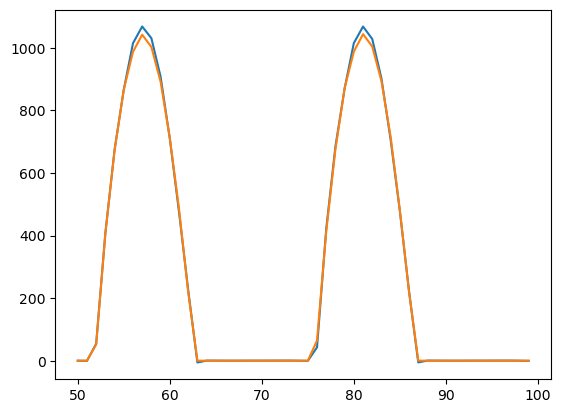

In [57]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [58]:

val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1.flatten()})
val_results.head(20)

274/274 [==============================] - 1s 5ms/step


,Val Predictions,Actuals
0,0.152401,0.00
1,0.249992,0.00
2,0.225632,0.00
3,-0.213323,0.00
4,-0.616825,0.00
5,97.532967,87.44
6,441.184875,429.21
7,702.814636,701.00
8,891.181213,896.93
9,1026.300903,1032.36


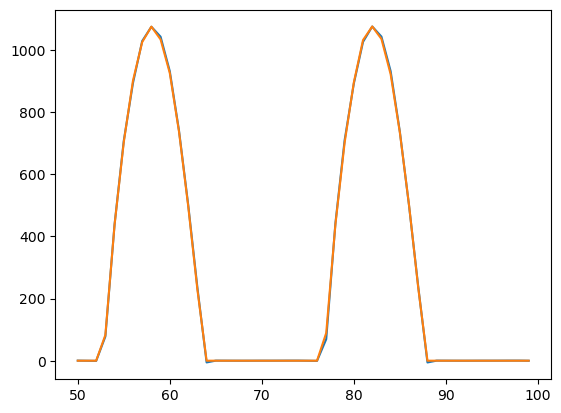

In [59]:
plt.plot(val_results['Val Predictions'][50:100])
plt.plot(val_results['Actuals'][50:100])

In [60]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1.flatten()})
test_results

822/822 [==============================] - 4s 5ms/step


,Test Predictions,Actuals
0,0.316673,0.00
1,0.314903,0.00
2,-0.054024,0.00
3,-0.589585,0.00
4,6.071582,26.93
...,...,...
26274,0.013195,0.00
26275,-0.020417,0.00
26276,0.033107,0.00
26277,0.119970,0.00


In [61]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=50, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

822/822 [==============================] - 4s 5ms/step


(       Predictions  Actuals
 0         0.316673     0.00
 1         0.314903     0.00
 2        -0.054024     0.00
 3        -0.589585     0.00
 4         6.071582    26.93
 ...            ...      ...
 26274     0.013195     0.00
 26275    -0.020417     0.00
 26276     0.033107     0.00
 26277     0.119970     0.00
 26278     0.116626     0.00
 
 [26279 rows x 2 columns],
 5392.964826996144)

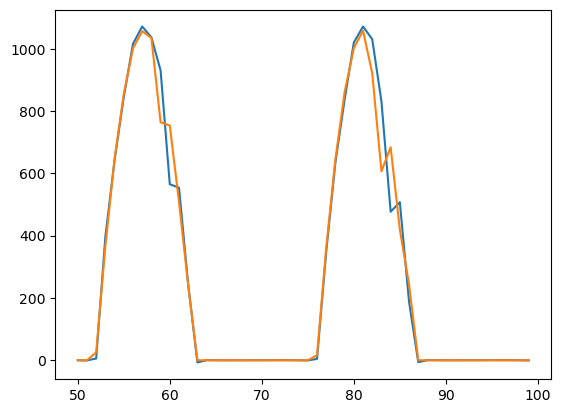

In [62]:
plot_predictions1(model1, X_test1, y_test1.flatten())

In [64]:
kkk = df_scaled[78866:78890,0]
print(type(kkk))
print(kkk.shape)
reshaped_array = np.reshape(kkk, (1, 24, 1))
print(reshaped_array)
predictions = model1.predict(reshaped_array)
print(predictions)
 
# original= scaler.inverse_transform(predictions)
# print(original)
# predictions
# inverse_data = np.zeros((len(predictions), scaler.shape[1]))

<class 'numpy.ndarray'>
(24,)
[[[   0.  ]
  [   0.  ]
  [  32.27]
  [ 390.79]
  [ 662.61]
  [ 859.19]
  [ 984.91]
  [1037.92]
  [1002.38]
  [ 894.79]
  [ 712.07]
  [ 467.98]
  [ 205.25]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]
  [   0.  ]]]
1/1 [==============================] - 0s 432ms/step
[[-0.07666707]]


In [65]:

input = df_scaled[78866:78890,0]  # Initial input extracted from your original scaled DataFrame
output_scaled = []  
output_not_scaled = [] 

for i in range(24):
    # Reshape input for the model prediction
    reshaped_array = np.reshape(input, (1, 24, 1))
    prediction = model1.predict(reshaped_array)
    
    # Reshape the prediction to match the input shape if necessary
    # Adjust the reshaping based on the actual shape of your model's output
    prediction_reshaped = np.reshape(prediction, (1, 1))
    input = np.reshape(input, (24, 1))  # Ensure input is in the correct shape before appending
    # Append the new prediction at the end of the input array
    input = np.vstack([input, prediction_reshaped])  # Stack vertically to add as a new row
    
    # Remove the oldest entry to maintain the sliding window of input data
    input = input[1:, :]  # Keep the last 5 entries, including the newly added prediction
 
    output_scaled.append(prediction)


# print(output_scaled)  # Remains empty, uncomment if needed
print(output_scaled)  # Print or process the predictions as 




1/1 [==============================] - 0s 21ms/step
[array([[-0.07666707]], dtype=float32), array([[-0.5833508]], dtype=float32), array([[25.588148]], dtype=float32), array([[392.2785]], dtype=float32), array([[661.3135]], dtype=float32), array([[854.82434]], dtype=float32), array([[1015.55554]], dtype=float32), array([[1075.8792]], dtype=float32), array([[1021.60425]], dtype=float32), array([[891.7514]], dtype=float32), array([[699.6407]], dtype=float32), array([[461.90833]], dtype=float32), array([[206.21126]], dtype=float32), array([[-5.3592505]], dtype=float32), array([[0.43459487]], dtype=float32), array([[0.25480843]], dtype=float32), array([[0.04706502]], dtype=float32), array([[-0.03712416]], dtype=float32), array([[-0.05537009]], dtype=float32), array([[-0.0477618]], dtype=float32), array([[0.05007696]], dtype=float32), array([[0.15944135]], dtype=float32), array([[0.19856024]], dtype=float32), array([[0.12685478]], dtype=float32)]


In [66]:
print("this is the real scaled output")
for i in output_scaled:
    print(i[0][0])

this is the real scaled output
-0.07666707
-0.5833508
25.588148
392.2785
661.3135
854.82434
1015.55554
1075.8792
1021.60425
891.7514
699.6407
461.90833
206.21126
-5.3592505
0.43459487
0.25480843
0.04706502
-0.037124157
-0.055370092
-0.047761798
0.05007696
0.15944135
0.19856024
0.12685478
